### Download fastText and facebook infersent models
Followed steps at: https://github.com/facebookresearch/InferSent

In [2]:
import nltk
nltk.download('punkt')
import sys
sys.path.append("../lib/Infersent")
from models import InferSent
import torch
import pandas as pd
import spacy
import numpy as np
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ryanstonebraker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048, 'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load('../models/encoder/infersent2.pkl'))
infersent.set_w2v_path("../models/fastText/crawl-300d-2M.vec")

In [4]:
squad_df = pd.read_csv("../corpora/squad-dev-v2.0.csv", index_col=0)
squad_df.head()

,contexts,questions,answer_texts,answer_starts
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,159
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,94
2,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,in the 10th and 11th centuries,87
3,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256
4,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,308


In [16]:
pd.set_option('max_colwidth', 100)
squad_df.sample(5)

,contexts,questions,answer_texts,answer_starts
2971,NASA's CALIPSO satellite has measured the amount of dust transported by wind from the Sahara to ...,How many tons of dust remains in the air?,132 million tons,441
5666,"When a consolidation referendum was held in 1967, voters approved the plan. On October 1, 1968, ...",What was Jacksonville referred to as after the consolidation?,"""Bold New City of the South""",428
6907,"Natural killer cells, or NK cells, are a component of the innate immune system which does not di...",MHC antigens on normal body cells are recognized by what receptor on NK cells?,killer cell immunoglobulin receptors (KIR),993
3717,Baran developed the concept of distributed adaptive message block switching during his research ...,What concept was developed by Baran while researching at RAND,distributed adaptive message block switching,31
3500,"Before World War II, Fresno had many ethnic neighborhoods, including Little Armenia, German Town...",What was the Fresno Fairgrounds used as?,an assembly center,580


In [29]:
nlp = spacy.load("en")

In [36]:
sentences = []

contexts = list(squad_df["contexts"].drop_duplicates())
for context in contexts:
    doc = nlp(context)
    sentences += [sentence.string.strip() for sentence in doc.sents]

In [37]:
infersent.build_vocab(sentences, tokenize=True)

Found 18481(/19809) words with w2v vectors
Vocab size : 18481


In [38]:
embeddings = infersent.encode(sentences, tokenize=True)

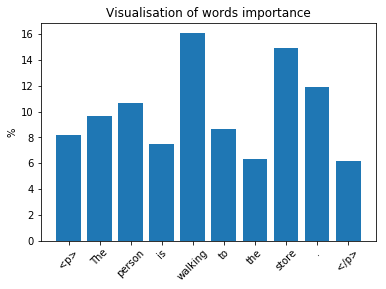

(tensor([[ 0.0075, -0.0281,  0.0683,  ..., -0.0171, -0.0331, -0.0084]],
        grad_fn=<MaxBackward0>), array([[0, 2, 4, ..., 7, 5, 1]]))

In [43]:
infersent.visualize('The person is walking to the store.', tokenize=True)

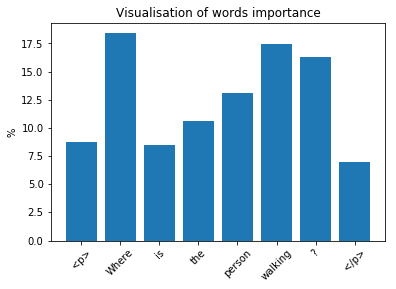

(tensor([[ 0.0075, -0.0292,  0.0551,  ..., -0.0055, -0.0356, -0.0193]],
        grad_fn=<MaxBackward0>), array([[0, 1, 5, ..., 3, 6, 1]]))

In [44]:
infersent.visualize('Where is the person walking?', tokenize=True)

In [50]:
def cosine_similarity(text1, text2):
    return np.dot(text1, text2)/(np.linalg.norm(text1) * np.linalg.norm(text2))

In [125]:
def split_sentences(paragraph):
    doc = nlp(paragraph)
    return [sentence.string.strip() for sentence in doc.sents]

In [124]:
def cosine_predict(statements, question):
    context_sentences = split_sentences(statements)
    most_similar, highest_sim = "", 0
    for sentence in context_sentences:
        similarity = cosine_similarity(infersent.encode([question])[0], infersent.encode([sentence])[0])
        if similarity > highest_sim:
            most_similar = sentence
            highest_sim = similarity
    return most_similar, highest_sim

In [92]:
sample_size = 100
correct_answers = 0
for i, row in tqdm(squad_df.sample(n=sample_size).iterrows(), total=sample_size):
    most_similar, accuracy = cosine_predict(row["contexts"], row["questions"])    
    correct_answers += 1 if row["answer_texts"] in most_similar else 0
print(f"Cosine Similarity Accuracy: {correct_answers/total}")


Cosine Similarity Accuracy: 0.7


In [167]:
# sample = squad_df.sample(n=1).iloc(0)[0]
sample = squad_df.iloc[7629]
sample.head()

contexts         Prime numbers have influenced many artists and...
questions        Which French composer wrote ametrical music us...
answer_texts                                      Olivier Messiaen
answer_starts                                                   76
Name: 7629, dtype: object

In [169]:
sample.contexts

'Prime numbers have influenced many artists and writers. The French composer Olivier Messiaen used prime numbers to create ametrical music through "natural phenomena". In works such as La Nativité du Seigneur (1935) and Quatre études de rythme (1949–50), he simultaneously employs motifs with lengths given by different prime numbers to create unpredictable rhythms: the primes 41, 43, 47 and 53 appear in the third étude, "Neumes rythmiques". According to Messiaen this way of composing was "inspired by the movements of nature, movements of free and unequal durations".'

In [168]:
statements = split_sentences(sample["contexts"])
options = {"compact": True, "bg": "#323a48", "color": "white", "font": "Source Sans Pro"}
spacy.displacy.render(nlp(statements[0]), style="dep", options=options)

In [174]:
statements

['Prime numbers have influenced many artists and writers.',
 'The French composer Olivier Messiaen used prime numbers to create ametrical music through "natural phenomena".',
 'In works such as La Nativité du Seigneur (1935) and Quatre études de rythme (1949–50), he simultaneously employs motifs with lengths given by different prime numbers to create unpredictable rhythms: the primes 41, 43, 47 and 53 appear in the third étude, "Neumes rythmiques".',
 'According to Messiaen this way of composing was "inspired by the movements of nature, movements of free and unequal durations".']

In [175]:
cosine_predict(sample.contexts, sample.questions)

('The French composer Olivier Messiaen used prime numbers to create ametrical music through "natural phenomena".',
 0.7370639)

In [185]:
statements = "The air was cold. The cat was orange. The cat walked across the grass. A bird flew in the sky."
question = "Where did the cat walk?"
cosine_predict(statements, question)

('The cat walked across the grass.', 0.48702246)

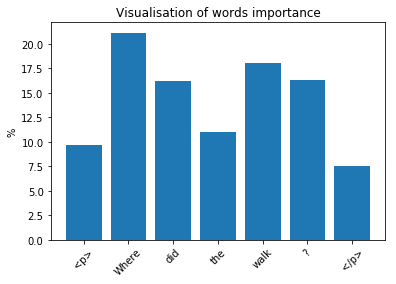

(tensor([[ 0.0075, -0.0292,  0.0664,  ...,  0.0401,  0.0146, -0.0329]],
        grad_fn=<MaxBackward0>), array([[0, 1, 4, ..., 2, 4, 5]]))

In [179]:
infersent.visualize(question, tokenize=True)

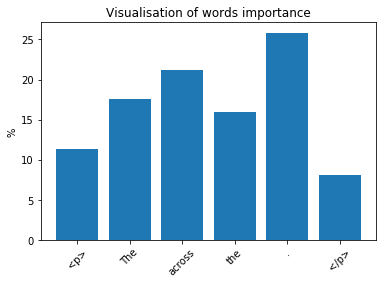

(tensor([[ 0.0075, -0.0695,  0.0447,  ..., -0.0573,  0.0130, -0.0139]],
        grad_fn=<MaxBackward0>), array([[0, 1, 2, ..., 2, 2, 4]]))

In [183]:
infersent.visualize("The cat walked across the grass.", tokenize=True)

In [ ]:
# TODO: Random Forest, Log Regression, RNN, AWD-LSTM, Make class for QA model to seed chatbot text gen